In [ ]:
import gc 
gc.collect()

# Temporal Response Function (TRF) - Visualization

### Modules 

In [1]:
import mne 
import pickle
import os
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

### Define dictionaries, subject, & conditions

In [ ]:
# path to data files
data_path = ".../data/"

# frequency band 
band_name = "Low Frequencies"
band = "deltatheta" 

# list of conditions
condition_list = ['produce_music', 'perceive_music_produced', 'produce_speech', 'perceive_speech_produced']
contrasts = [["produce_music", "perceive_music_produced"], ["produce_speech", "perceive_speech_produced"]]
pairs = [["music","produce_music"], ["music", "perceive_music_produced"], ["speech", "produce_speech"], ["speech", "perceive_speech_produced"]]
contrasts = [["produce_music", "perceive_music_produced"], ["produce_speech", "perceive_speech_produced"]]
condition_names = ["Music \n Production", "Music \n Perception", "Speech \n Production", "Speech \n Perception"]
contrast_names = ["Music Production And Music Perception", "Speech Production and Speech Perception"]

condition_list_control = ['perceive_music_new', 'perceive_music_newrepetition', 'perceive_speech_new', 'perceive_speech_newrepetition']
contrasts_control = [["perceive_music_new", "perceive_music_newrepetition"], ["perceive_speech_new", "perceive_speech_newrepetition"]]
pairs_control = [["perceive_music_new", "perceive_music_newrepetition"], ["speech_new", "perceive_speech_new"], ["speech_new", "perceive_speech_newrepetition"]]
condition_names_control = ["Music \n Perception \n Control", "Music \n Perception \n Control Repetition", "Speech \n Perception \n Control", "Speech \n Perception \n Control Repetition", ]
contrast_names_control = ["Music First Hearing And Music Second Hearing", "Speech First Hearing and Speech Second Hearing"]


### Load raw data and channel information 

In [5]:
# load in raw 
raw = {}

for condition in condition_list:
    preprocessed_path = data_path + "/preprocessed/" + condition + "/"

    for files in os.listdir(preprocessed_path):
        print(files)
        filename = "day1_bipolar_raw_preprocessed.fif"
        print(filename)
        if filename in files:
            path = preprocessed_path + files + '/'
            print(path)
            raw[condition] =  mne.io.read_raw_fif(path, preload=True)

auditory_produce_music_day1_bipolar_raw_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
/Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/produce_music/auditory_produce_music_day1_bipolar_raw_preprocessed.fif/
Opening raw data file /Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/produce_music/auditory_produce_music_day1_bipolar_raw_preprocessed.fif/...


    Range : 123030 ... 423030 =    123.030 ...   423.030 secs
Ready.
Reading 0 ... 300000  =      0.000 ...   300.000 secs...
auditory_produce_music_day2_bipolar_raw_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_produce_music_epochs_day1_bipolar_epochs_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_produce_music_epochs_day2_bipolar_epochs_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_perceive_music_produced_day1_bipolar_raw_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
/Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/perceive_music_produced/auditory_perceive_music_produced_day1_bipolar_raw_preprocessed.fif/
Opening raw data file /Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/perceive_music_produced/auditory_perceive_music_produced_day1_bipolar_raw_preprocessed.fif/...
    Range : 52196 ... 352196 =     52.196 ...   352.196 secs
Ready.
Reading 0 ... 300000  =      0.000 ...   300.000 secs...


/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/371709477.py:14: RuntimeWarning: This filename (/Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/produce_music/auditory_produce_music_day1_bipolar_raw_preprocessed.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw[condition] =  mne.io.read_raw_fif(path, preload=True)
/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/371709477.py:14: RuntimeWarning: This filename (/Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/perceive_music_produced/auditory_perceive_music_produced_day1_bipolar_raw_preprocessed.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.g

auditory_perceive_music_produced_day2_bipolar_raw_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_perceive_music_produced_epochs_day2_bipolar_epochs_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_perceive_music_produced_epochs_day1_bipolar_epochs_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_produce_speech_epochs_day2_bipolar_epochs_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_produce_speech_day1_bipolar_raw_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
/Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/produce_speech/auditory_produce_speech_day1_bipolar_raw_preprocessed.fif/
Opening raw data file /Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/produce_speech/auditory_produce_speech_day1_bipolar_raw_preprocessed.fif/...
    Range : 32320 ... 332320 =     32.320 ...   332.320 secs
Ready.
Reading 0 ... 300000  =      0.000 ...   300.000 secs...
auditory_produce_speech_epochs_day1_bipolar_epo

/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/371709477.py:14: RuntimeWarning: This filename (/Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/produce_speech/auditory_produce_speech_day1_bipolar_raw_preprocessed.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw[condition] =  mne.io.read_raw_fif(path, preload=True)
/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/371709477.py:14: RuntimeWarning: This filename (/Users/annalorenz/Documents/Research/INS_Paper/data_pub/preprocessed/perceive_speech_produced/auditory_perceive_speech_produced_day1_bipolar_raw_preprocessed.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.f

auditory_perceive_speech_produced_day2_bipolar_raw_preprocessed.fif
day1_bipolar_raw_preprocessed.fif
auditory_perceive_speech_produced_epochs_day2_bipolar_epochs_preprocessed.fif
day1_bipolar_raw_preprocessed.fif


In [6]:
# channel names (picks)
picks_H = raw['produce_music'].ch_names
print('channels in auditory cortex: ', picks_H)

# assign channels to LH and RH primary and non-primary auditory cortex 
picks_primary_RH = ['H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'H10-H11']
picks_primary_LH = [ "H'5-H'6", "H'6-H'7", "H'7-H'8", "H'8-H'9"]
picks_nonprimary_RH = ['H11-H12', 'H12-H13']
picks_nonprimary_LH = [ "H'9-H'10", "H'10-H'11", "H'11-H'12"]

picks_subset = [picks_primary_LH, picks_nonprimary_LH, picks_primary_RH, picks_nonprimary_RH,]
picks_subset_names = ["Left Primary Auditory Cortex", "Left Associative Auditory Cortex", "Right Primary Auditory Cortex", "Right Associative Auditory Cortex"] 


channels in auditory cortex:  ['H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'H10-H11', 'H11-H12', 'H12-H13', "H'5-H'6", "H'6-H'7", "H'7-H'8", "H'8-H'9", "H'9-H'10", "H'10-H'11", "H'11-H'12"]


### Load accoustic regressors and TRF data

In [7]:
# regressors  
with open(f"{data_path}/analysis/TRF/TRF_regressors_deltatheta_day1.pickle", 'rb') as f:
        regressors1 = pickle.load(f)

with open(f"{data_path}/analysis/TRF/TRF_regressors_deltatheta_day2.pickle", 'rb') as f:
        regressors2 = pickle.load(f)


In [8]:
# load TRF crossvalidated data for H-channels 
with open(f"{data_path}/analysis/TRF/TRF_results_deltatheta_day1_crossvalidate.pickle", 'rb') as f:
        TRF1 = pickle.load(f)

with open(f"{data_path}/analysis/TRF/TRF_results_deltatheta_day2_crossvalidate.pickle", 'rb') as f:
        TRF2 = pickle.load(f)

In [9]:
# parameters 
labels = regressors1['music'][1]
fs = 100
scoring = 'r2'
tw = [-0.2, 0.5]                                           

# Compare conditions

## Self Produced Speech and Music: Production - Perception 

In [10]:
# concatenate data from two days
TRF = {}
for condition in condition_list: 
        TRF[condition] = {}
        for pick in picks_H: 
                TRF[condition][pick] = {}
                TRF[condition][pick]['score'] = np.concatenate((TRF1[condition][pick]['score'], TRF2[condition][pick]['score']), axis=0)
                TRF[condition][pick]['coefs'] = np.concatenate((TRF1[condition][pick]['coefs'], TRF2[condition][pick]['coefs']), axis=0)
                TRF[condition][pick]['predicted_Y'] = np.concatenate((TRF1[condition][pick]['predicted_Y'], TRF2[condition][pick]['predicted_Y']), axis=0)
                TRF[condition][pick]['times'] = TRF1[condition][pick]['times'] 


In [11]:
# load TRF for main analysis for day1
TRF_day1 = {}
for condition in condition_list: 
        TRF_day1[condition] = {}
        for pick in picks_H: 
                TRF_day1[condition][pick] = {}
                TRF_day1[condition][pick]['score'] = TRF1[condition][pick]['score']
                TRF_day1[condition][pick]['coefs'] = TRF1[condition][pick]['coefs']
                TRF_day1[condition][pick]['predicted_Y'] = TRF1[condition][pick]['predicted_Y']
                TRF_day1[condition][pick]['times'] = TRF1[condition][pick]['times'] 

# load TRF for main analysis for day1
TRF_day2 = {}
for condition in condition_list: 
        TRF_day2[condition] = {}
        for pick in picks_H: 
                TRF_day2[condition][pick] = {}
                TRF_day2[condition][pick]['score'] = TRF2[condition][pick]['score']
                TRF_day2[condition][pick]['coefs'] = TRF2[condition][pick]['coefs']
                TRF_day2[condition][pick]['predicted_Y'] = TRF2[condition][pick]['predicted_Y']
                TRF_day2[condition][pick]['times'] = TRF2[condition][pick]['times'] 

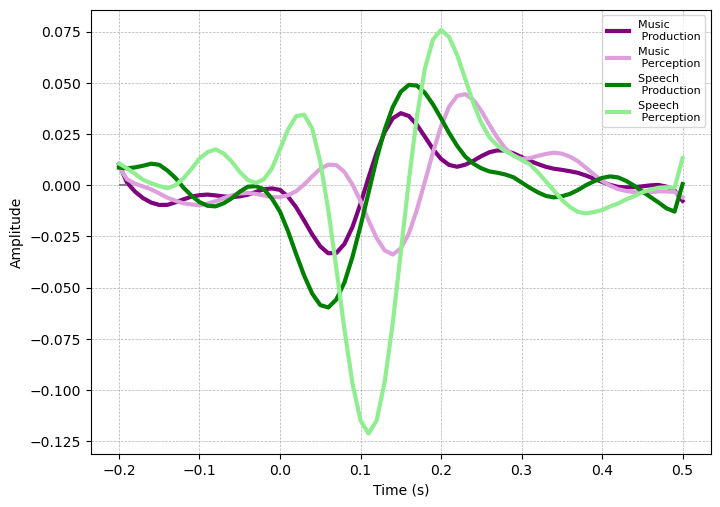

In [12]:
# TRF shape 
pick = 'H5-H6'
i_reg = 5 # loadness derivative
colors = ['purple', 'plum', '#008000', '#90EE90']

fig, ax = plt.subplots(figsize=(8,6))
fig.subplots_adjust(top=0.85)

for n, condition in enumerate(condition_list):
    times = TRF[condition][pick]['times']

    coefs_pick = TRF[condition][pick]["coefs"]
    coefs_mean = np.mean(coefs_pick[:, i_reg, :], axis=0)
    ax.plot(times, coefs_mean, label=condition_names[n], color=colors[n], linewidth=3)


ax.hlines(0, times[0], times[1], colors='gray', linestyles='--')

ax.legend(loc='upper right', prop={'size': 8})
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
plt.show()  

/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/524480884.py:24: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)
/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/524480884.py:24: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)


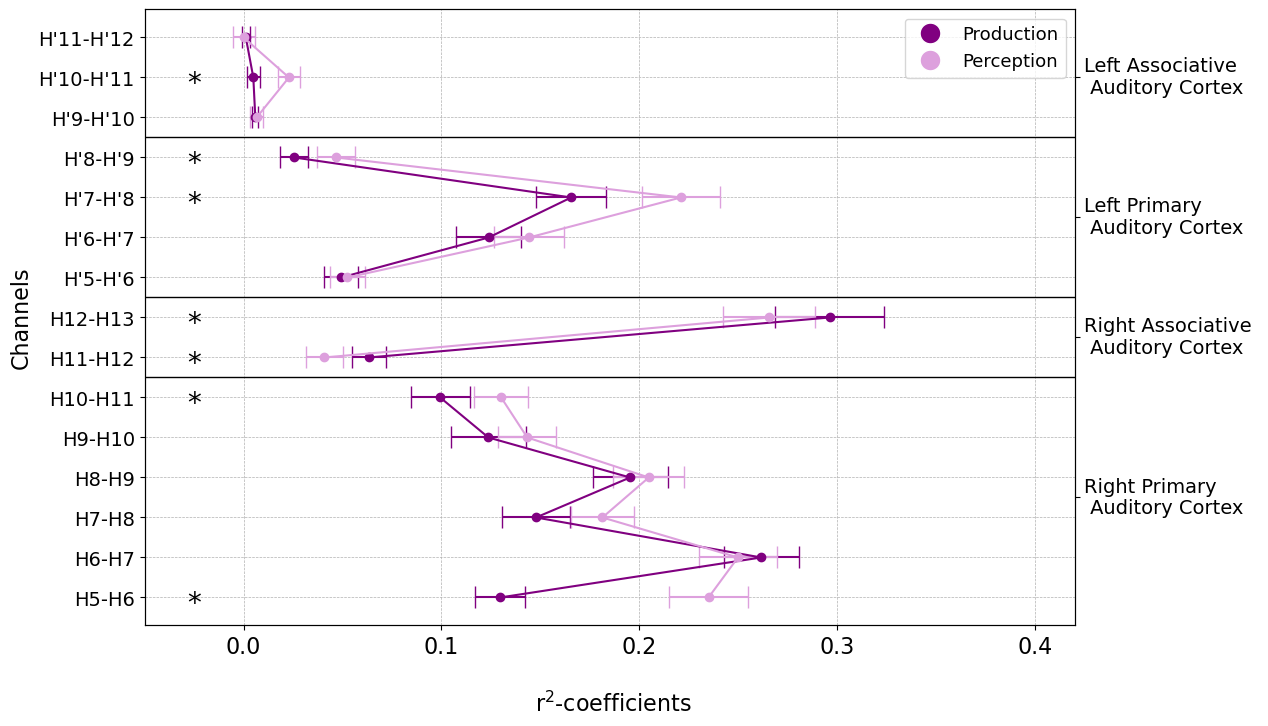

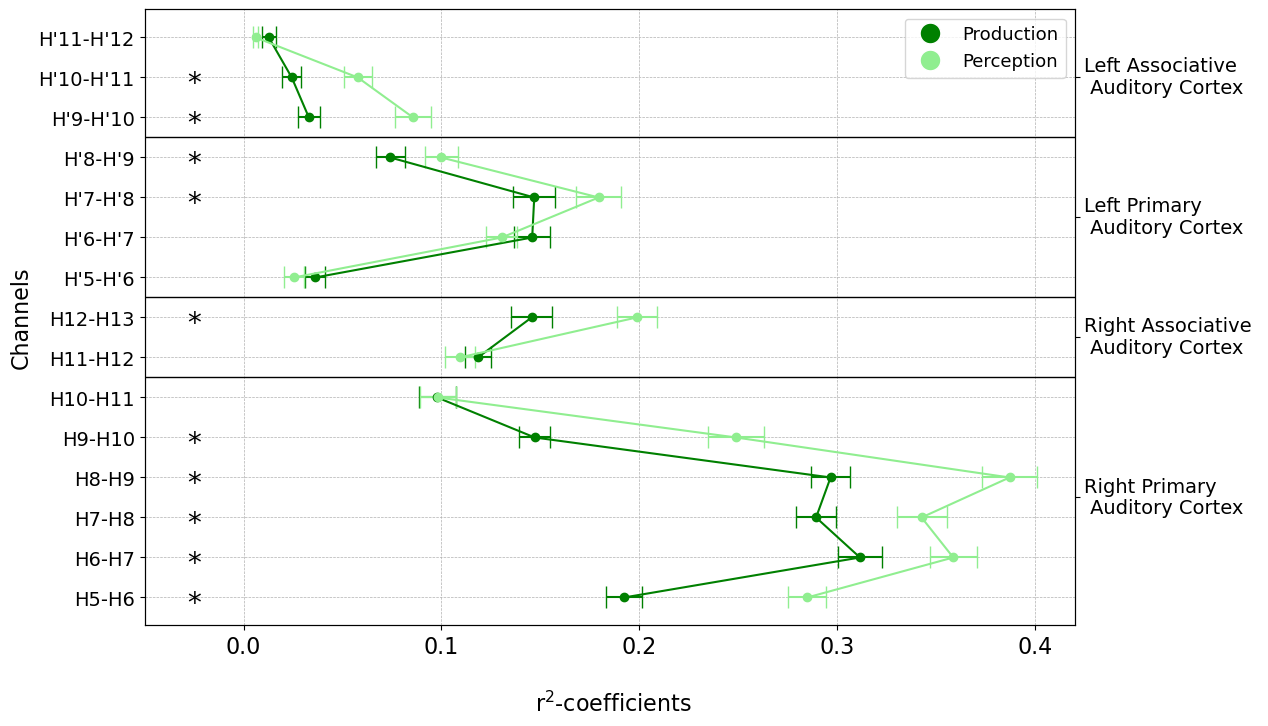

In [13]:
brain_label = ["Right Primary \n Auditory Cortex", "Right Associative \n Auditory Cortex", "Left Primary \n Auditory Cortex", "Left Associative \n Auditory Cortex"]
channel_position = [[0,5], [6,7], [8,11], [11,len(picks_H)]]
channel_assignment = [0, 6, 8, 12, len(picks_H)]

for n, contrast in enumerate(contrasts):
    if "music" in contrast[0]: 
        color_prod = 'purple'
        color_perc = 'plum'
    elif "speech" in contrast[0]: 
        color_prod = '#008000'
        color_perc = '#90EE90'

        
    data_production = np.array([TRF[contrast[0]][pick]['score'] for pick in picks_H])
    data_perception = np.array([TRF[contrast[1]][pick]['score'] for pick in picks_H])

    mean_production = np.mean(data_production, axis=1)
    se_production = np.std(data_production, axis=1, ddof=1) / np.sqrt(len(data_production[0]))

    mean_perception = np.mean(data_perception, axis=1)
    se_perception = np.std(data_perception, axis=1, ddof=1) / np.sqrt(len(data_perception[0]))

    # t-test
    t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)
    p_corrected = multipletests(p.flatten(), method='fdr_bh')[1].reshape(p.shape)    
    significance_threshold = 0.05
    significant_channels = np.where(p_corrected < significance_threshold)[0]

    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax2 = ax.twinx()  
  
    ## plot means, se  
    for c in range(len(channel_assignment)-1):
        ax.errorbar(mean_production[channel_assignment[c]:channel_assignment[c+1]], picks_H[channel_assignment[c]:channel_assignment[c+1]], xerr=se_production[channel_assignment[c]:channel_assignment[c+1]], marker='o', color=color_prod, capsize=8)
        ax.errorbar(mean_perception[channel_assignment[c]:channel_assignment[c+1]], picks_H[channel_assignment[c]:channel_assignment[c+1]], xerr=se_perception[channel_assignment[c]:channel_assignment[c+1]], marker='o', color=color_perc, capsize=8)
    
    ## plot significant differences
    for s in range(len(picks_H)):
        if p_corrected[s] < 0.05:
            x_pos = - 0.025
            y_pos = s - 0.15
            ax.text(x_pos, y_pos, "*", fontsize=20, color='black', ha='center', va='center', zorder=3)

    #ax.set_title(f'r$^2$ Coeffients for {contrast_names[n]} \n', fontsize=16)
    ax.set_xlabel('\n r$^2$-coefficients', fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel('Channels', fontsize=16)
    ax.set_xlim([-0.05, 0.42])
    ax.set_yticks(np.arange(len(picks_H)))
    ax.set_yticklabels(picks_H, fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    for channel_pos_index in [[0,5], [5,7], [7,11]]: 
        ax.axhline(channel_pos_index[1] + 0.5, color="black", lw=1)
    ax2.set_ylim(ax.get_ylim()) 
    channel_midpoints = [(index[0] + index[1]) / 2 for index in channel_position]
    ax2.set_yticks(channel_midpoints)  
    ax2.set_yticklabels(brain_label, size=14, va='center')  

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_prod, markersize=15, label='Production'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_perc, markersize=15, label='Perception')
    ]

    ax.legend(handles=legend_handles, fontsize=13) 
plt.show()

/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/2053433402.py:25: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)
/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/2053433402.py:25: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)


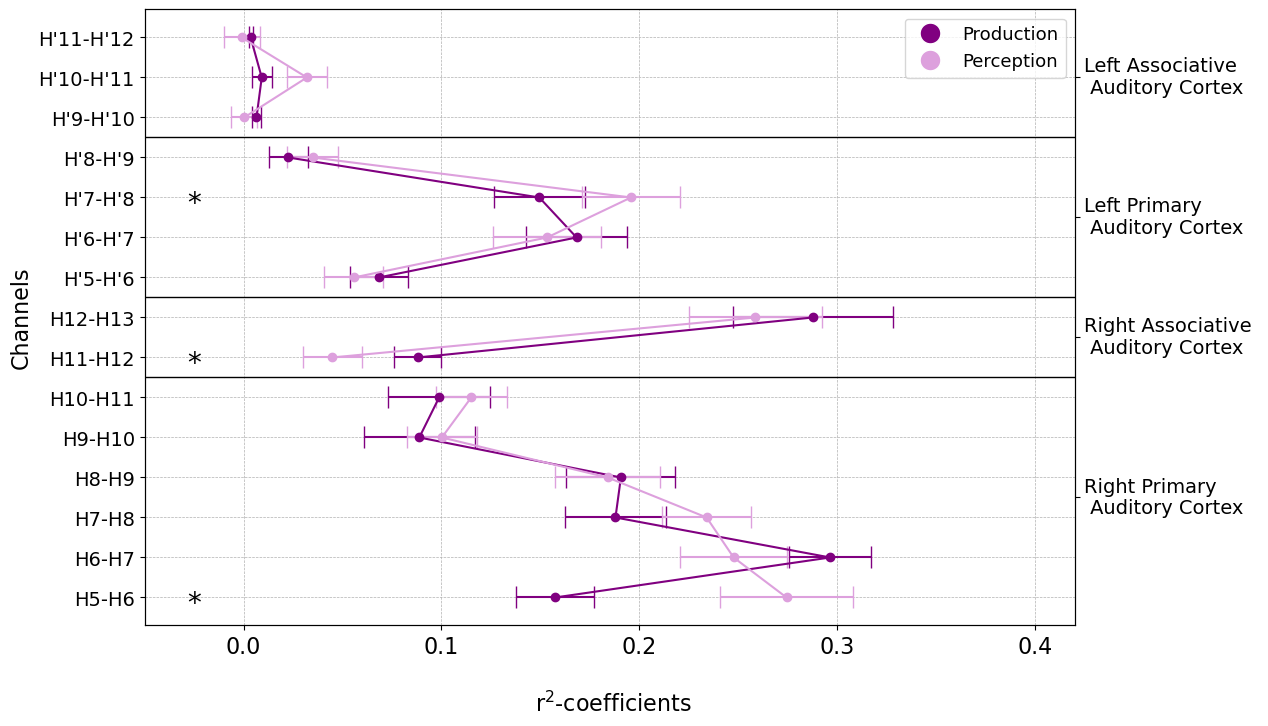

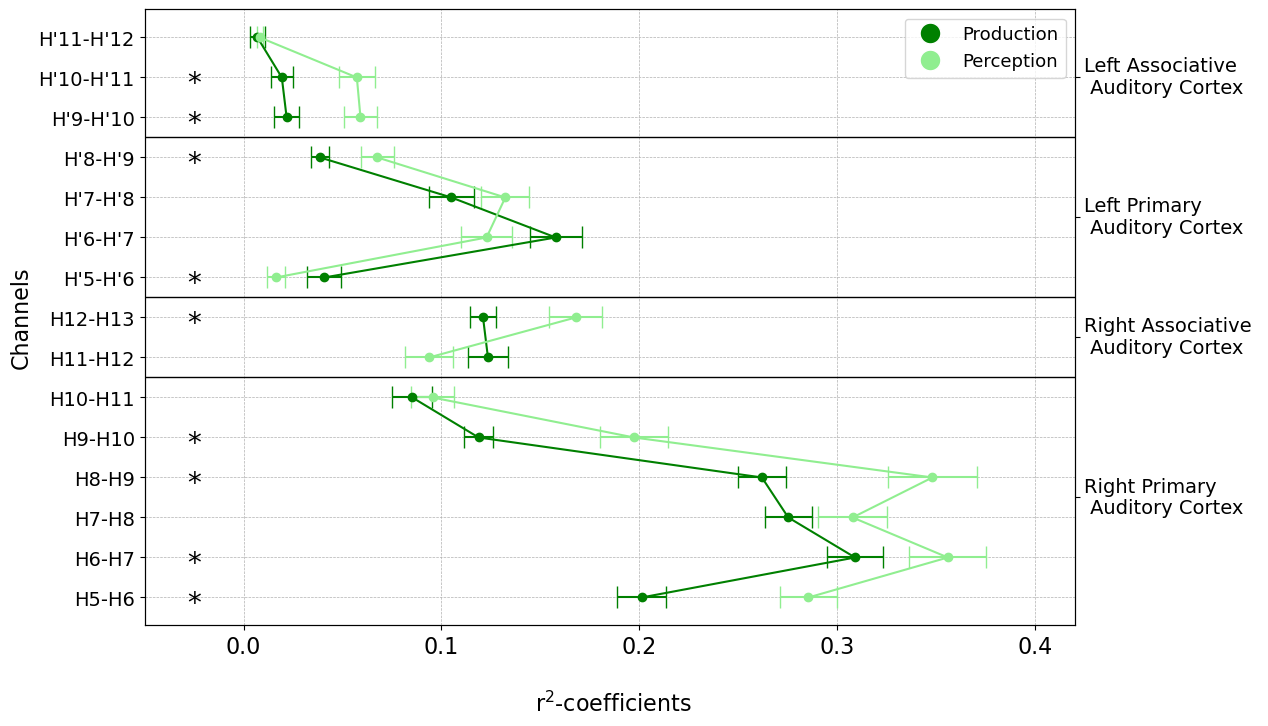

/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/2053433402.py:25: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)
/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/2053433402.py:25: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)


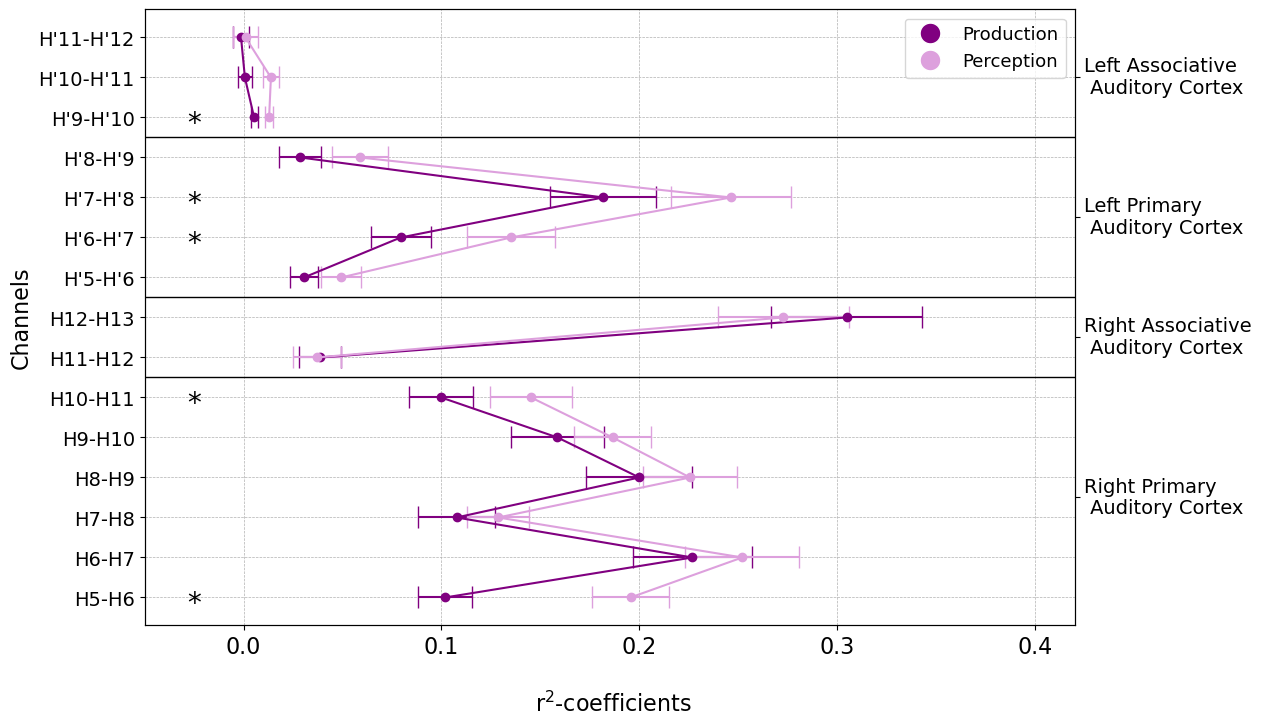

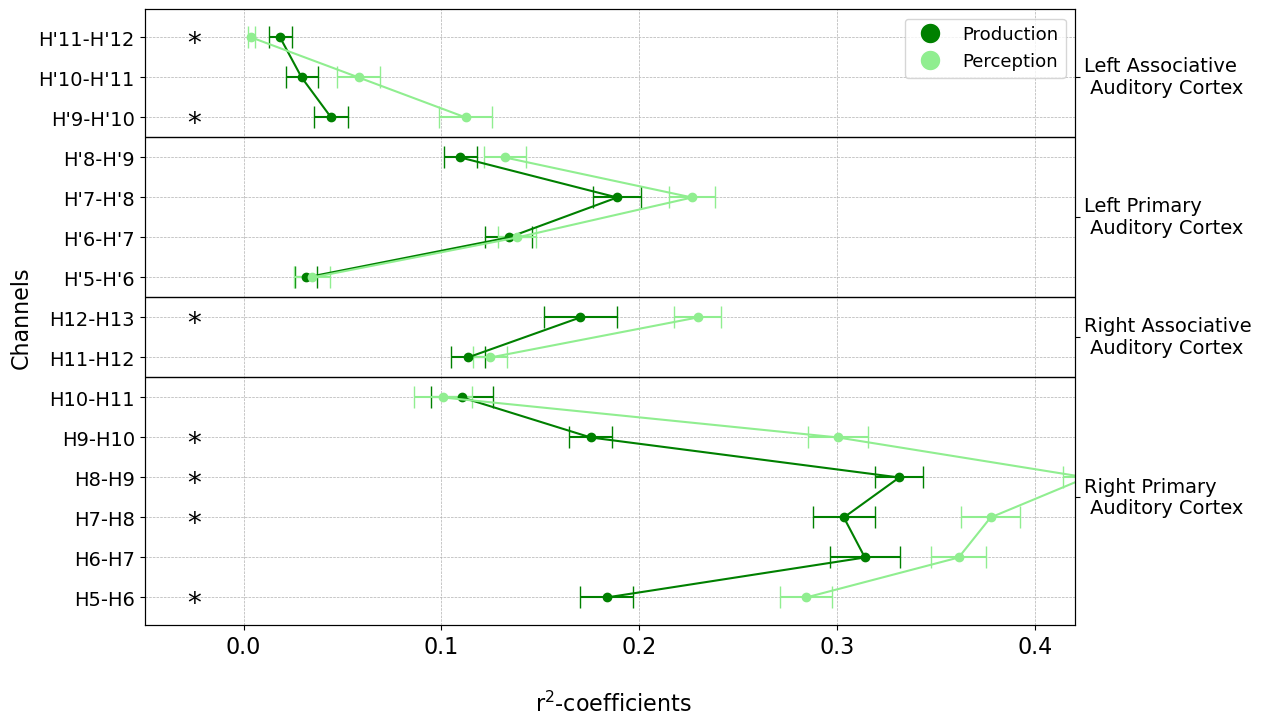

In [14]:
# plot seperatly for the days 
brain_label = ["Right Primary \n Auditory Cortex", "Right Associative \n Auditory Cortex", "Left Primary \n Auditory Cortex", "Left Associative \n Auditory Cortex"]
channel_position = [[0,5], [6,7], [8,11], [11,len(picks_H)]]
channel_assignment = [0, 6, 8, 12, len(picks_H)]

for day, TRF in zip(['Day1', 'Day2'], [TRF1, TRF2]):
    for n, contrast in enumerate(contrasts):
        if "music" in contrast[0]: 
            color_prod = 'purple'
            color_perc = 'plum'
        elif "speech" in contrast[0]: 
            color_prod = '#008000'
            color_perc = '#90EE90'

        data_production = np.array([TRF[contrast[0]][pick]['score'] for pick in picks_H])
        data_perception = np.array([TRF[contrast[1]][pick]['score'] for pick in picks_H])

        mean_production = np.mean(data_production, axis=1)
        se_production = np.std(data_production, axis=1, ddof=1) / np.sqrt(len(data_production[0]))

        mean_perception = np.mean(data_perception, axis=1)
        se_perception = np.std(data_perception, axis=1, ddof=1) / np.sqrt(len(data_perception[0]))

        # t-test
        t, p = stats.stats.ttest_rel(data_production.T, data_perception.T)
        p_corrected = multipletests(p.flatten(), method='fdr_bh')[1].reshape(p.shape)    
        significance_threshold = 0.05
        significant_channels = np.where(p_corrected < significance_threshold)[0]

        # plot
        fig, ax = plt.subplots(figsize=(12, 8))
        ax2 = ax.twinx()  
    
        ## plot means, se  
        for c in range(len(channel_assignment)-1):
            ax.errorbar(mean_production[channel_assignment[c]:channel_assignment[c+1]], picks_H[channel_assignment[c]:channel_assignment[c+1]], xerr=se_production[channel_assignment[c]:channel_assignment[c+1]], marker='o', color=color_prod, capsize=8)
            ax.errorbar(mean_perception[channel_assignment[c]:channel_assignment[c+1]], picks_H[channel_assignment[c]:channel_assignment[c+1]], xerr=se_perception[channel_assignment[c]:channel_assignment[c+1]], marker='o', color=color_perc, capsize=8)
        

        ## plot significant differences
        for s in range(len(picks_H)):
            if p_corrected[s] < 0.05:
                x_pos = - 0.025
                y_pos = s - 0.15
                ax.text(x_pos, y_pos, "*", fontsize=20, color='black', ha='center', va='center', zorder=3)

        ax.set_xlabel('\n r$^2$-coefficients', fontsize=16)
        ax.tick_params(axis='x', labelsize=16)
        ax.set_ylabel('Channels', fontsize=16)
        ax.set_xlim([-0.05, 0.42])
        ax.set_yticks(np.arange(len(picks_H)))
        ax.set_yticklabels(picks_H, fontsize=14)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        for channel_pos_index in [[0,5], [5,7], [7,11]]: 
            ax.axhline(channel_pos_index[1] + 0.5, color="black", lw=1)
        ax2.set_ylim(ax.get_ylim()) 
        channel_midpoints = [(index[0] + index[1]) / 2 for index in channel_position]
        ax2.set_yticks(channel_midpoints)  
        ax2.set_yticklabels(brain_label, size=14, va='center')  

        legend_handles = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_prod, markersize=15, label='Production'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_perc, markersize=15, label='Perception')
        ]

        ax.legend(handles=legend_handles, fontsize=13) 
    plt.show()

## Linear mixed effects model 


In [15]:
def custom_round(val, threshold=1e-5, decimals=3):
    if abs(val) < threshold:
        return f"{val:.{decimals}e}"
    else:
        return round(val, decimals)

In [16]:
# Define channel groups
picks_primary_RH = ['H5-H6', 'H6-H7', 'H7-H8', 'H8-H9', 'H9-H10', 'H10-H11']
picks_primary_LH = ["H'5-H'6", "H'6-H'7", "H'7-H'8", "H'8-H'9"]
picks_nonprimary_RH = ['H11-H12', 'H12-H13']
picks_nonprimary_LH = ["H'9-H'10", "H'10-H'11", "H'11-H'12"]

# Create a dictionary for mapping channels to regions
channel_to_region = {}

# Add each channel group to the mapping
for ch in picks_primary_RH:
    channel_to_region[ch] = 'Primary_RH'
for ch in picks_primary_LH:
    channel_to_region[ch] = 'Primary_LH'
for ch in picks_nonprimary_RH:
    channel_to_region[ch] = 'Non_primary_RH'
for ch in picks_nonprimary_LH:
    channel_to_region[ch] = 'Non_primary_LH'

### Model for music

In [17]:
data = []
for day, TRF in zip(['Day1', 'Day2'], [TRF1, TRF2]):
    for condition in ['produce_music', 'perceive_music_produced']:
        for pick in picks_H:
            score = TRF[condition][pick]['score']
            for sc in score:  
                data.append({'Condition': condition, 'Day': day, 'Channel': pick, 'Score': sc})


data_music = pd.DataFrame(data)

data_music['Condition'] = pd.Categorical(data_music['Condition'], 
                                          categories=['produce_music', 'perceive_music_produced'],
                                          ordered=True)
data_music['Region'] = data_music['Channel'].map(channel_to_region)

In [18]:
# Model 
model = smf.mixedlm("Score ~ C(Condition)", data_music, groups=data_music["Channel"]).fit(reml=False)
#print(model.summary())

results_list = []
if model:
    params = model.params
    pvalues = model.pvalues
    aic = model.aic
    bic = model.bic
    std_errs = model.bse  
    tvalues = model.tvalues  
    conf_int = model.conf_int()  
    
    for effect, coefficient in params.items():
        t_value = tvalues.get(effect, None)
        std_err = std_errs.get(effect, None)
        lower_bound, upper_bound = conf_int.loc[effect].values
        
        results_list.append({
            "effect": effect,
            "coef": custom_round(coefficient),  
            "SE": custom_round(std_err),        
            "p": custom_round(pvalues.get(effect, None)),  
            "t": custom_round(t_value),        
            "[0.025": custom_round(lower_bound),  
            "0.975]": custom_round(upper_bound), 
            #"AIC": custom_round(aic),           
            #"BIC": custom_round(bic),          
        })

results_df = pd.DataFrame(results_list)


/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [19]:
# Compare Models 
model_results = {}
results_list = []

# Model 1: Fixed effect of Condition 
model1 = smf.mixedlm(
    formula="Score ~ C(Condition)",  
    data=data_music,
    groups=data_music["Channel"]  
).fit(reml=False)
model_results[band_name] = {"Model Condition": model1}


# Model 2: Fixed effects of Condition and Region
model2 = smf.mixedlm(
    formula="Score ~ C(Condition) + C(Region)",  
    data=data_music,
    groups=data_music["Channel"]  
).fit(reml=False)

model_results[band_name]["Model Condition + Region"] = model2

# Likelihood Ratio Test statistic
ll_model_1 = model1.llf  
ll_model_2 = model2.llf  
num_params_model_1 = len(model1.params)
num_params_model_2 = len(model2.params)

lr_statistic = 2 * (ll_model_2 - ll_model_1)
df_diff = num_params_model_2 - num_params_model_1
p_value = 1 - stats.chi2.cdf(lr_statistic, df_diff)

print(f"Likelihood Ratio Test between Model 1 and Model 2: Statistic = {lr_statistic}, p-value = {p_value}")

results_list.append({
    "Stimuli": "music", 
    "Model1": "Condition",
    "Model2": "Condition + Region",
    "AIC_Model1": model1.aic,
    "BIC_Model1": model1.bic,
    "AIC_Model2": model2.aic,
    "BIC_Model2": model2.bic,
    "Log-Likelihood_Model1": ll_model_1,
    "Log-Likelihood_Model1": ll_model_2,
    "LR Statistic": lr_statistic,
    "p-value": p_value
})


df_results = pd.DataFrame(results_list)


Likelihood Ratio Test between Model 1 and Model 2: Statistic = 11.290731113172114, p-value = 0.01025331222261816


/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [20]:
# Compare Models 
model_results = {}
results_list = []

# Model 1: Fixed effect of Condition 
model1 = smf.mixedlm(
    formula="Score ~ C(Condition) + C(Region)",  
    data=data_music,
    groups=data_music["Channel"]  
).fit(reml=False)
model_results[band_name] = {"Model Condition + Region": model1}


# Model 2: Fixed effects of Condition and Region
model2 = smf.mixedlm(
    formula="Score ~ C(Condition) * C(Region)",  
    data=data_music,
    groups=data_music["Channel"]  
).fit(reml=False)

model_results[band_name]["Model Condition * Region"] = model2

# Likelihood Ratio Test statistic
ll_model_1 = model1.llf  
ll_model_2 = model2.llf  
num_params_model_1 = len(model1.params)
num_params_model_2 = len(model2.params)

lr_statistic = 2 * (ll_model_2 - ll_model_1)
df_diff = num_params_model_2 - num_params_model_1
p_value = 1 - stats.chi2.cdf(lr_statistic, df_diff)

print(f"Likelihood Ratio Test between Model 1 and Model 2: Statistic = {lr_statistic}, p-value = {p_value}")

results_list.append({
    "Stimuli": "music", 
    "Model1": "Condition + Region",
    "Model2": "Condition * Region",
    "AIC_Model1": model1.aic,
    "BIC_Model1": model1.bic,
    "AIC_Model2": model2.aic,
    "BIC_Model2": model2.bic,
    "Log-Likelihood_Model1": ll_model_1,
    "Log-Likelihood_Model1": ll_model_2,
    "LR Statistic": lr_statistic,
    "p-value": p_value
})

df_results = pd.DataFrame(results_list)

Likelihood Ratio Test between Model 1 and Model 2: Statistic = 12.549871543664267, p-value = 0.005718415538130239


/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
# Model 
model = smf.mixedlm("Score ~ C(Condition) * C(Region)", data_music, groups=data_music["Channel"]).fit(reml=False)
#print(model.summary())

results_list = []
if model:
    params = model.params
    pvalues = model.pvalues
    aic = model.aic
    bic = model.bic
    std_errs = model.bse  
    tvalues = model.tvalues  
    conf_int = model.conf_int()  
    
    for effect, coefficient in params.items():
        t_value = tvalues.get(effect, None)
        std_err = std_errs.get(effect, None)
        lower_bound, upper_bound = conf_int.loc[effect].values
        
        results_list.append({
            "effect": effect,
            "coef": coefficient,  
            "SE": std_err,        
            "p": pvalues.get(effect, None),  
            "t": t_value,        
            "[0.025": lower_bound,  
            "0.975]": upper_bound, 
            "AIC": aic,           
            "BIC": bic,          
        })

results_df = pd.DataFrame(results_list)


/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


#### Model for speech

In [22]:
data = []
for day, TRF in zip(['Day1', 'Day2'], [TRF1, TRF2]):
    for condition in ['produce_speech', 'perceive_speech_produced']:
        for pick in picks_H:
            score = TRF[condition][pick]['score']
            for sc in score:  
                data.append({'Condition': condition, 'Day': day, 'Channel': pick, 'Score': sc})

data_speech = pd.DataFrame(data)

data_speech['Condition'] = pd.Categorical(data_speech['Condition'], 
                                          categories=['produce_speech', 'perceive_speech_produced'],
                                          ordered=True)
data_speech['Region'] = data_speech['Channel'].map(channel_to_region)

In [23]:
# Original model 
model = smf.mixedlm("Score ~ C(Condition)", data_speech, groups=data_speech["Channel"]).fit(reml=False)
#print(model.summary())

results_list = []
if model:
    params = model.params
    pvalues = model.pvalues
    aic = model.aic
    bic = model.bic
    std_errs = model.bse  
    tvalues = model.tvalues  
    conf_int = model.conf_int()  
    
    for effect, coefficient in params.items():
        t_value = tvalues.get(effect, None)
        std_err = std_errs.get(effect, None)
        lower_bound, upper_bound = conf_int.loc[effect].values
        
        results_list.append({
            "effect": effect,
            "coef": custom_round(coefficient),  
            "SE": custom_round(std_err),        
            "p": custom_round(pvalues.get(effect, None)),  
            "t": custom_round(t_value),        
            "[0.025": custom_round(lower_bound),  
            "0.975]": custom_round(upper_bound), 
            #"AIC": custom_round(aic),           
            #"BIC": custom_round(bic),          
        })

results_df = pd.DataFrame(results_list)

In [24]:
# Compare Models 
model_results = {}
results_list = []

# Model 1: Fixed effect of Condition 
model1 = smf.mixedlm(
    formula="Score ~ C(Condition)",  
    data=data_speech,
    groups=data_speech["Channel"]  
).fit(reml=False)
model_results[band_name] = {"Model Condition": model1}


# Model 2: Fixed effects of Condition and Region
model2 = smf.mixedlm(
    formula="Score ~ C(Condition) + C(Region)",  
    data=data_speech,
    groups=data_speech["Channel"]  
).fit(reml=False)

model_results[band_name]["Model Condition + Region"] = model2

# Likelihood Ratio Test statistic
ll_model_1 = model1.llf  
ll_model_2 = model2.llf  
num_params_model_1 = len(model1.params)
num_params_model_2 = len(model2.params)

lr_statistic = 2 * (ll_model_2 - ll_model_1)
df_diff = num_params_model_2 - num_params_model_1
p_value = 1 - stats.chi2.cdf(lr_statistic, df_diff)

print(f"Likelihood Ratio Test between Model 1 and Model 2: Statistic = {lr_statistic}, p-value = {p_value}")

results_list.append({
    "Stimuli": "speech", 
    "Model1": "Condition",
    "Model2": "Condition + Region",
    "AIC_Model1": model1.aic,
    "BIC_Model1": model1.bic,
    "AIC_Model2": model2.aic,
    "BIC_Model2": model2.bic,
    "Log-Likelihood_Model1": ll_model_1,
    "Log-Likelihood_Model1": ll_model_2,
    "LR Statistic": lr_statistic,
    "p-value": p_value
})

df_results = pd.DataFrame(results_list)

Likelihood Ratio Test between Model 1 and Model 2: Statistic = 15.932731003129447, p-value = 0.001170568498029101


/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [25]:
# Compare Models 
model_results = {}
results_list = []

# Model 1: Fixed effect of Condition 
model1 = smf.mixedlm(
    formula="Score ~ C(Condition) + C(Region)",  
    data=data_speech,
    groups=data_speech["Channel"]  
).fit(reml=False)
model_results[band_name] = {"Model Condition + Region": model1}


# Model 2: Fixed effects of Condition and Region
model2 = smf.mixedlm(
    formula="Score ~ C(Condition) * C(Region)",  
    data=data_speech,
    groups=data_speech["Channel"]  
).fit(reml=False)

model_results[band_name]["Model Condition * Region"] = model2

# Likelihood Ratio Test statistic
ll_model_1 = model1.llf  
ll_model_2 = model2.llf  
num_params_model_1 = len(model1.params)
num_params_model_2 = len(model2.params)

lr_statistic = 2 * (ll_model_2 - ll_model_1)
df_diff = num_params_model_2 - num_params_model_1
p_value = 1 - stats.chi2.cdf(lr_statistic, df_diff)

print(f"Likelihood Ratio Test between Model 1 and Model 2: Statistic = {lr_statistic}, p-value = {p_value}")

results_list.append({
    "Stimuli": "speech", 
    "Model1": "Condition + Region",
    "Model2": "Condition * Region",
    "AIC_Model1": model1.aic,
    "BIC_Model1": model1.bic,
    "AIC_Model2": model2.aic,
    "BIC_Model2": model2.bic,
    "Log-Likelihood_Model1": ll_model_1,
    "Log-Likelihood_Model1": ll_model_2,
    "LR Statistic": lr_statistic,
    "p-value": p_value
})

df_results = pd.DataFrame(results_list)

/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Likelihood Ratio Test between Model 1 and Model 2: Statistic = 47.91747285339079, p-value = 2.2173551883497566e-10


/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [26]:
# Model 
model = smf.mixedlm("Score ~ C(Condition) * C(Region)", data_speech, groups=data_speech["Channel"]).fit(reml=False)
#print(model.summary())

results_list = []
if model:
    params = model.params
    pvalues = model.pvalues
    aic = model.aic
    bic = model.bic
    std_errs = model.bse  
    tvalues = model.tvalues  
    conf_int = model.conf_int()  
    
    for effect, coefficient in params.items():
        t_value = tvalues.get(effect, None)
        std_err = std_errs.get(effect, None)
        lower_bound, upper_bound = conf_int.loc[effect].values
        
        results_list.append({
            "effect": effect,
            "coef": coefficient,  
            "SE": std_err,        
            "p": pvalues.get(effect, None),  
            "t": t_value,        
            "[0.025": lower_bound,  
            "0.975]": upper_bound, 
            "AIC": aic,           
            "BIC": bic,          
        })

results_df = pd.DataFrame(results_list)

/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Speech and Music Repetition: First Hearing - Second Hearing 

In [27]:
# load TRF for control conditions
TRF_control = {}
for condition in condition_list_control: 
        TRF_control[condition] = {}
        for pick in picks_H: 
                TRF_control[condition][pick] = {}
                TRF_control[condition][pick]['score'] = TRF1[condition][pick]['score']
                TRF_control[condition][pick]['coefs'] = TRF1[condition][pick]['coefs']
                TRF_control[condition][pick]['predicted_Y'] = TRF1[condition][pick]['predicted_Y']
                TRF_control[condition][pick]['times'] = TRF1[condition][pick]['times'] 

/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/1373400135.py:23: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_firsthearing.T, data_secondhearing.T)
/var/folders/68/4crvzft135s2_qq0dbp6slhw0000gn/T/ipykernel_73237/1373400135.py:23: DeprecationWarning: Please use `ttest_rel` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p = stats.stats.ttest_rel(data_firsthearing.T, data_secondhearing.T)


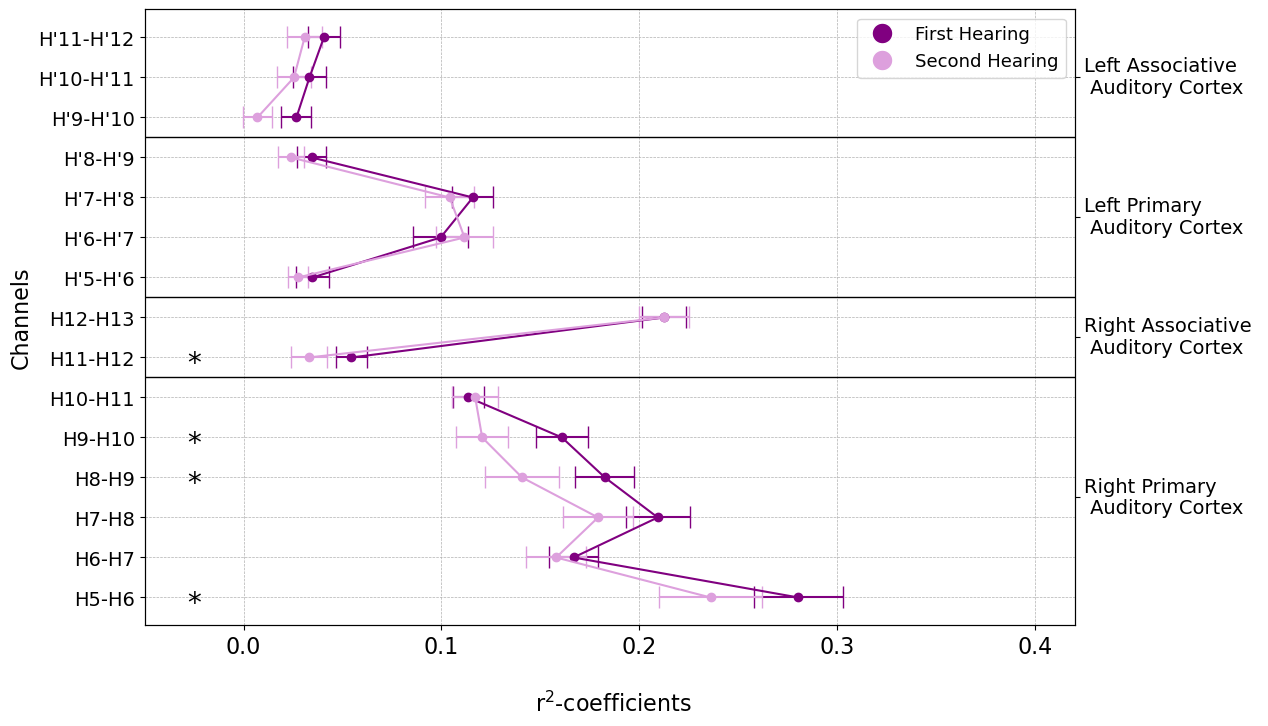

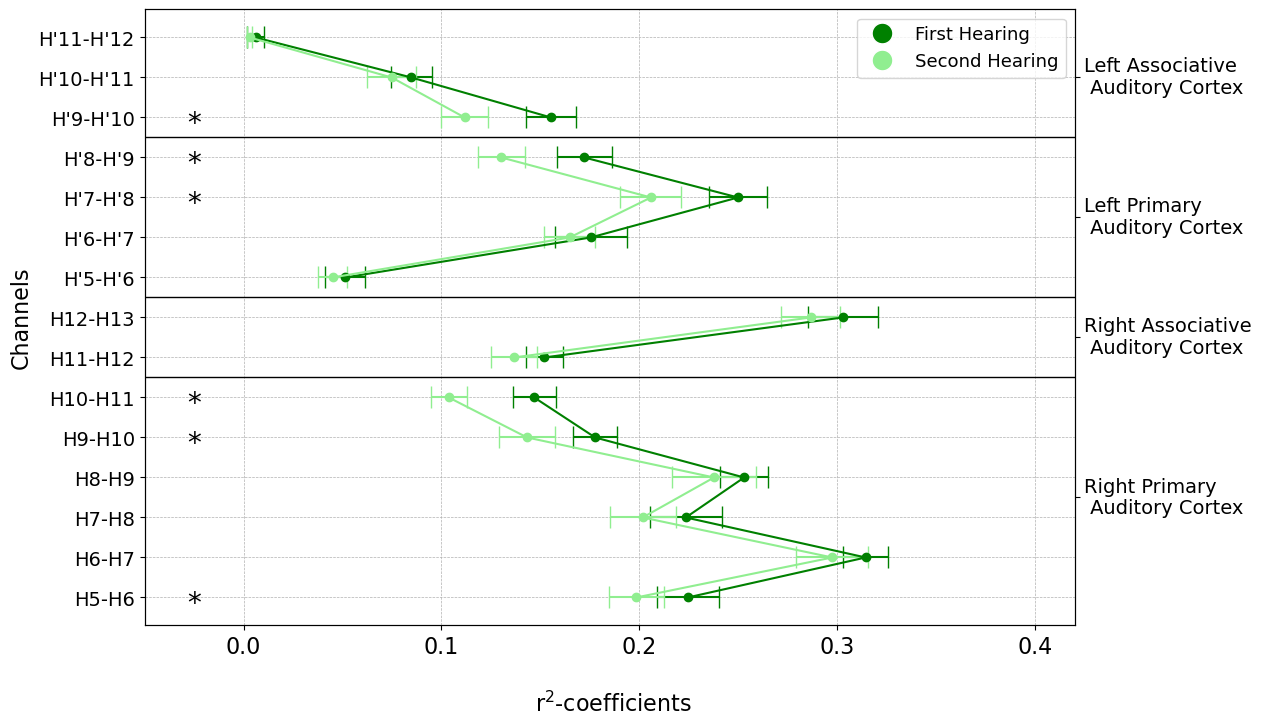

In [28]:
brain_label = ["Right Primary \n Auditory Cortex", "Right Associative \n Auditory Cortex", "Left Primary \n Auditory Cortex", "Left Associative \n Auditory Cortex"]
channel_position = [[0,5], [6,7], [8,11], [11,len(picks_H)]]
channel_assignment = [0, 6, 8, 12, len(picks_H)]

for n, contrast in enumerate(contrasts_control):
    if "music" in contrast[0]: 
        color_prod = 'purple'
        color_perc = 'plum'
    elif "speech" in contrast[0]: 
        color_prod = '#008000'
        color_perc = '#90EE90'

    data_firsthearing = np.array([TRF_control[contrast[0]][pick]['score'] for pick in picks_H])
    data_secondhearing = np.array([TRF_control[contrast[1]][pick]['score'] for pick in picks_H])

    mean_firsthearing = np.mean(data_firsthearing, axis=1)
    se_firsthearing = np.std(data_firsthearing, axis=1, ddof=1) / np.sqrt(len(data_firsthearing[0]))

    mean_secondhearing = np.mean(data_secondhearing, axis=1)
    se_secondhearing = np.std(data_secondhearing, axis=1, ddof=1) / np.sqrt(len(data_secondhearing[0]))

    # t-test
    t, p = stats.stats.ttest_rel(data_firsthearing.T, data_secondhearing.T)
    p_corrected = multipletests(p.flatten(), method='fdr_bh')[1].reshape(p.shape)    
    significance_threshold = 0.05
    significant_channels = np.where(p_corrected < significance_threshold)[0]

    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax2 = ax.twinx()  
  
    ## plot means, se  
    for c in range(len(channel_assignment)-1):
        ax.errorbar(mean_firsthearing[channel_assignment[c]:channel_assignment[c+1]], picks_H[channel_assignment[c]:channel_assignment[c+1]], xerr=se_firsthearing[channel_assignment[c]:channel_assignment[c+1]], marker='o', color=color_prod, capsize=8)
        ax.errorbar(mean_secondhearing[channel_assignment[c]:channel_assignment[c+1]], picks_H[channel_assignment[c]:channel_assignment[c+1]], xerr=se_secondhearing[channel_assignment[c]:channel_assignment[c+1]], marker='o', color=color_perc, capsize=8)
    

    ## plot significant differences
    for s in range(len(picks_H)):
        if p_corrected[s] < 0.05:
            x_pos = - 0.025
            y_pos = s - 0.15
            ax.text(x_pos, y_pos, "*", fontsize=20, color='black', ha='center', va='center', zorder=3)

    ax.set_xlabel('\n r$^2$-coefficients', fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel('Channels', fontsize=16)
    ax.set_xlim([-0.05, 0.42])
    ax.set_yticks(np.arange(len(picks_H)))
    ax.set_yticklabels(picks_H, fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    for channel_pos_index in [[0,5], [5,7], [7,11]]: 
        ax.axhline(channel_pos_index[1] + 0.5, color="black", lw=1)
    ax2.set_ylim(ax.get_ylim()) 
    channel_midpoints = [(index[0] + index[1]) / 2 for index in channel_position]
    ax2.set_yticks(channel_midpoints)  
    ax2.set_yticklabels(brain_label, size=14, va='center')  

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_prod, markersize=15, label='First Hearing'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_perc, markersize=15, label='Second Hearing')
    ]

    ax.legend(handles=legend_handles, fontsize=13) 
plt.show()

## Linear Mixed Effect Model

### Model for music

In [29]:
data = []
for condition in ['perceive_music_new', 'perceive_music_newrepetition']:
    for pick in picks_H:
        score = TRF_control[condition][pick]['score']
        for sc in score:  
            data.append({'Condition': condition, 'Channel': pick, 'Score': sc})

data_music = pd.DataFrame(data)

data_music['Condition'] = pd.Categorical(data_music['Condition'], 
                                          categories=['perceive_music_new', 'perceive_music_newrepetition'],
                                          ordered=True)         

In [30]:
model = smf.mixedlm("Score ~ C(Condition)", data_music, groups=data_music["Channel"]).fit(reml=False)
#print(model.summary())

results_list = []
if model:
    params = model.params
    pvalues = model.pvalues
    aic = model.aic
    bic = model.bic
    std_errs = model.bse  
    tvalues = model.tvalues  
    conf_int = model.conf_int()  
    
    for effect, coefficient in params.items():
        t_value = tvalues.get(effect, None)
        std_err = std_errs.get(effect, None)
        lower_bound, upper_bound = conf_int.loc[effect].values
        
        results_list.append({
            "effect": effect,
            "coef": custom_round(coefficient),  
            "SE": custom_round(std_err),        
            "p": custom_round(pvalues.get(effect, None)),  
            "t": custom_round(t_value),        
            "[0.025": custom_round(lower_bound),  
            "0.975]": custom_round(upper_bound), 
            #"AIC": custom_round(aic),           
            #"BIC": custom_round(bic),          
        })

results_df = pd.DataFrame(results_list)

/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


#### Model for speech 

In [31]:
data = []
for condition in ['perceive_speech_new', 'perceive_speech_newrepetition']:
    for pick in picks_H:
        score = TRF_control[condition][pick]['score']
        for sc in score:  
            data.append({'Condition': condition, 'Channel': pick, 'Score': sc})

data_speech = pd.DataFrame(data)

data_speech['Condition'] = pd.Categorical(data_speech['Condition'], 
                                          categories=['perceive_speech_new', 'perceive_speech_newrepetition'],
                                          ordered=True)

In [32]:

model = smf.mixedlm("Score ~ C(Condition)", data_speech, groups=data_speech["Channel"]).fit(reml=False)

results_list = []
if model:
    params = model.params
    pvalues = model.pvalues
    aic = model.aic
    bic = model.bic
    std_errs = model.bse  
    tvalues = model.tvalues  
    conf_int = model.conf_int()  
    
    for effect, coefficient in params.items():
        t_value = tvalues.get(effect, None)
        std_err = std_errs.get(effect, None)
        lower_bound, upper_bound = conf_int.loc[effect].values
        
        results_list.append({
            "effect": effect,
            "coef": custom_round(coefficient),  
            "SE": custom_round(std_err),        
            "p": custom_round(pvalues.get(effect, None)),  
            "t": custom_round(t_value),        
            "[0.025": custom_round(lower_bound),  
            "0.975]": custom_round(upper_bound), 
            #"AIC": custom_round(aic),           
            #"BIC": custom_round(bic),          
        })

results_df = pd.DataFrame(results_list)

/Users/annalorenz/miniforge3/envs/ins_paper/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
